# Service optimization

In [1]:
import pandas as pd

blocks = pd.read_pickle('./../../data/blocks.pickle')
columns = [c for c in blocks.columns if 'capacity_' in c]
blocks = blocks[['geometry', 'population', 'site_area', *columns]].copy()
blocks.head(3)

,geometry,population,site_area,capacity_school,capacity_kindergarten,capacity_hospital,capacity_polyclinic,capacity_pitch,capacity_swimming_pool,capacity_theatre,...,capacity_train_station,capacity_bus_station,capacity_bus_stop,capacity_pier,capacity_animal_shelter,capacity_prison,capacity_landfill,capacity_plant_nursery,capacity_greenhouse_complex,capacity_warehouse
0,"POLYGON ((349424.859 6631180.891, 349424.751 6...",0.0,0.032316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((352083.617 6633950.146, 352240.448 6...",0.0,137101.088247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((346700.642 6618453.176, 346681.107 6...",109.0,95239.084434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
accessibility_matrix = pd.read_pickle('./../../data/acc_mx.pickle')
accessibility_matrix.head()

/home/ivan/work/ovanes-projects/urban-planning-optimizer/general/.venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,9358,9359,9360,9361,9362,9363,9364,9365,9366,9367
0,0.0000,58.15625,74.187500,76.937500,66.8125,80.5000,92.18750,66.56250,65.68750,106.8750,...,70.0000,72.1875,72.0000,73.3125,73.2500,74.0000,75.5000,83.1875,75.0000,73.2500
1,56.2500,0.00000,99.687500,102.375000,88.1250,76.1250,113.43750,89.43750,88.56250,96.3125,...,65.6250,67.7500,67.6875,69.0000,68.8750,69.6875,71.1875,78.8125,70.6875,68.8750
2,74.5000,96.50000,0.000000,5.347656,74.0000,118.8125,92.06250,64.43750,63.56250,134.5000,...,108.3125,110.4375,110.3750,111.6875,111.5625,112.3750,113.8125,121.5000,113.3750,111.5625
3,77.2500,99.25000,5.347656,0.000000,76.7500,121.5625,90.12500,67.18750,66.31250,137.2500,...,111.0625,113.1875,113.0625,114.3750,114.3125,115.0625,116.5625,124.2500,116.1250,114.3125
4,70.1875,90.56250,82.375000,85.125000,0.0000,110.5000,35.53125,45.15625,44.28125,89.8750,...,100.0000,102.1250,102.0000,103.3125,103.2500,104.0000,105.5000,113.1875,105.0000,103.2500


### Select ID of optimized blocks

In [3]:
from blocksnet.enums import LandUse
blocks_lu = {
    2059 : LandUse.RESIDENTIAL
}

### Service distribution

In [4]:
basic_services = {
    "kindergarten": 0.2,
    "school": 0.2,
    "pharmacy": 0.2,
    "polyclinics": 0.3,
    "convenience": 0.2,   
    "cafe": 0.15,
    "playground": 0.2,
    "post": 0.1,
    "hairdresser": 0.1
}
advanced_services = {
    "hospital": 0.5,
    "supermarket": 0.4,
    "restaurant": 0.3,
    "park": 0.8,
    "bank": 0.3,
    "fuel": 0.25,
    "police": 0.2,
    "cinema": 0.2,
    "market": 0.2,
    "religion": 0.5,
    "multifunctional_center": 0.1,
    "train_building": 0.1,
    "cemetery": 0.1,
    "notary": 0.1,
    "pitch": 0.2
}
comfort_services = {
    "mall": 0.3,
    "swimming_pool": 0.4,
    "theatre": 0.2,
    "museum": 0.2,
    "university": 0.2,
    "sanatorium": 0.2,
    "zoo": 0.1,
    "reserve": 0.1,
    "animal_shelter": 0.1,
    "aeroway_terminal": 0.2,
    "crematorium": 0.1,
    "prison": 0.1,
    "landfill": 0.1,
    "bar": 0.3,
    "hotel": 0.3,
}


def get_service_weight(service_name):
    if service_name in basic_services:
        return 0.5714 * basic_services[service_name]
    elif service_name in advanced_services:
        return 0.2857 * advanced_services[service_name]
    elif service_name in comfort_services:
        return 0.1429 * comfort_services[service_name]
    return 0

### Service types and weights

In [5]:
chosen_service_types = set(basic_services) | set(advanced_services) | set(comfort_services)
service_weights = {service_type: get_service_weight(service_type) for service_type in chosen_service_types if f'capacity_{service_type}' in blocks.columns}

### Initialize and run optimizer

In [6]:
from blocksnet.optimization.services import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    Facade,
    BlockSolution,
    GradientChooser,
    SimpleChooser,
    RandomOrder,
    AreaSolution
)
from tqdm import tqdm

var_adapter = AreaSolution(blocks_lu)

facade = Facade(
    blocks_lu=blocks_lu,
    blocks_df=blocks,
    accessibility_matrix=accessibility_matrix,
    var_adapter=var_adapter,
)

for service_type, weight in tqdm(service_weights.items()):
    facade.add_service_type(service_type, weight, blocks.rename(columns={f'capacity_{service_type}': 'capacity'})[['capacity']])

objective = WeightedObjective(num_params=facade.num_params, facade=facade, weights=service_weights, max_evals=100)

constraints = WeightedConstraints(num_params=facade.num_params, facade=facade, priority=service_weights)

tpe_optimizer = TPEOptimizer(
    objective=objective, constraints=constraints, vars_order=RandomOrder(), vars_chooser=GradientChooser(facade, num_params=facade.num_params, num_top=5)
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=1000, timeout=60000, initial_runs_num=1)

100%|██████████| 35/35 [13:15<00:00, 22.74s/it]
[I 2025-07-30 13:47:33,551] A new study created in memory with name: no-name-7236c4ec-218f-472c-9099-73a2aff3b9ff


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-07-30 13:47:36,172] Trial 0 finished with value: 1.7590525543245839 and parameters: {'x_12': 0, 'x_6': 700, 'x_5': 60, 'x_14': 10000, 'x_15': 0, 'x_24': 0, 'x_4': 400, 'x_19': 0, 'x_13': 50, 'x_23': 0, 'x_20': 0, 'x_11': 0, 'x_21': 100, 'x_17': 9100, 'x_1': 1000, 'x_9': 20000, 'x_2': 450, 'x_7': 270, 'x_25': 150, 'x_18': 2800, 'x_16': 0, 'x_0': 30, 'x_22': 3520, 'x_3': 18500, 'x_10': 0, 'x_8': 0}. Best is trial 0 with value: 1.7590525543245839.
[I 2025-07-30 13:47:38,178] Trial 1 finished with value: 1.7591407549631215 and parameters: {'x_17': 9100, 'x_18': 2802, 'x_9': 20001, 'x_8': 8, 'x_12': 0, 'x_4': 400, 'x_0': 30, 'x_19': 9, 'x_25': 151, 'x_6': 700, 'x_7': 276, 'x_13': 50, 'x_15': 3, 'x_1': 1000, 'x_11': 5, 'x_21': 100, 'x_14': 10006, 'x_20': 1, 'x_10': 0, 'x_3': 18512, 'x_24': 6, 'x_2': 450, 'x_16': 6, 'x_5': 61, 'x_23': 5, 'x_22': 3533}. Best is trial 1 with value: 1.7591407549631215.
[I 2025-07-30 13:47:40,099] Trial 2 finished with value: 1.7538942265405484 and parame

Convert to services dataframe

In [7]:
solution_df = facade.solution_to_services_df(best_x)
solution_df.to_csv(f'services.csv')
solution_df.head(5)

,block_id,service_type,site_area,build_floor_area,capacity,count
3,2059,convenience,0.0,25.0,50,1
8,2059,cinema,0.0,700.0,450,1
12,2059,bank,0.0,400.0,250,1
18,2059,school,0.0,2200.0,250,1
27,2059,bar,0.0,40.0,30,1


Extract area dataframe from solution

In [13]:
solution_area_df = facade.get_solution_area_df(best_x)
solution_area_df.to_csv(f'solution_area.csv')
solution_area_df.loc[blocks_lu.keys()].head(5)

,population,build_floor_area,living_area,footprint_area
2059,2631.0,79087.734512,28192.734512,14060.041691


### Visualization

In [9]:
import matplotlib.pyplot as plt


def plot_df(df):
    df_called_obj = df.loc[df["called_obj"] == True]

    plt.scatter(df_called_obj["func_evals"], df_called_obj["best_val"], c="red", s=5)

    df_called_obj = pd.concat(
        [pd.DataFrame([[-1, None, 0, 0, None, 0, False, 0]], columns=df_called_obj.columns), df_called_obj]
    )
    plt.plot(
        df_called_obj["func_evals"], df_called_obj["best_val"], label="Best Value (TPE)", color="blue", linewidth=1
    )
    # Добавление точек с цветом в зависимости от 'called_obj'
    # Настройка осей и заголовка
    plt.xlabel("Number of objective evaluation")
    plt.ylabel("Best Value")
    plt.title("Best Value Across Trials")
    plt.legend()
    plt.grid(True)

    # Отображение графика
    plt.show()

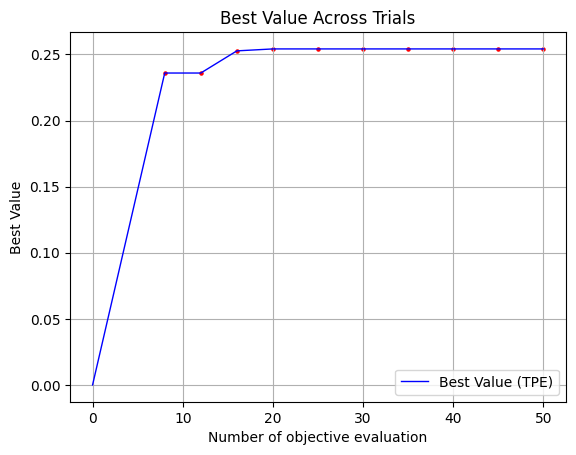

In [10]:
import pandas as pd

tpe_df = pd.read_csv("tpe_trials.csv")
plot_df(tpe_df)

In [11]:
facade.save_delta_demand(best_x)
population_df = pd.read_csv("demand_services.csv")
population_df.head(20)

,Block id,Service type,Demand
0,2059,convenience,473
1,2059,cinema,21
2,2059,bank,52
3,2059,school,315
4,2059,bar,65
5,2059,fuel,78
6,2059,police,13
7,2059,restaurant,186
8,2059,hairdresser,26
9,2059,university,34
